# Solar Models

In [82]:
# **Imports**
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Loading and Preparing the data

## Loading the Data 

In [83]:
local_path_target = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/Users/R/code/HaukeFock/predict_energy_generation/raw_data/hourly/features/hourly_globalradiation_df.csv"

data_target = pd.read_csv(local_path_target)
data_target['Date'] = pd.to_datetime(data_target.Date)
generation_df = data_target.groupby(by=data_target['Date']).sum()
solar_df = generation_df["Photovoltaics[MWh]"]


data_feature = pd.read_csv(local_path_feature)
data_feature['Date'] = pd.to_datetime(data_feature.Date)
data_feature = data_feature.set_index('Date')

# Preparing the Data




## Concatenating the Data

In [84]:
# making target and features dataframes compatible 
solar_df = solar_df[data_feature.index[0]:data_feature.index[-1]]
solar_df.shape

(11664,)

In [85]:
complete_df = pd.concat([solar_df, data_feature], axis=1)
complete_df.shape

(11664, 120)

## Filtering the data with highly correlated timeseries Optional 

In [86]:
# get correlation between generated energy and stations
sorted_corr = complete_df.corr().abs().iloc[0].sort_values(ascending=False)
list_of_corr_060 = list(sorted_corr[sorted_corr >= 0.6].index)

# select most correlated stations(over 0.6)
filtered_df = complete_df.copy()[list_of_corr_060]
filtered_df.drop(columns=['Photovoltaics[MWh]'], inplace=True)
filtered_df.shape

(11664, 116)

In [87]:
list_of_corr_060[1:]

['13674',
 '4177',
 '3660',
 '15000',
 '4336',
 '460',
 '5100',
 '5906',
 '3098',
 '2812',
 '4928',
 '2667',
 '3287',
 '2171',
 '953',
 '1639',
 '5480',
 '3761',
 '1078',
 '2485',
 '5705',
 '7374',
 '2712',
 '7368',
 '282',
 '1468',
 '1766',
 '3668',
 '1443',
 '5426',
 '1270',
 '198',
 '3028',
 '3231',
 '3268',
 '4887',
 '2601',
 '3167',
 '2925',
 '2638',
 '867',
 '5404',
 '2014',
 '232',
 '5397',
 '6197',
 '1346',
 '3366',
 '3126',
 '662',
 '2559',
 '2932',
 '2261',
 '5839',
 '3631',
 '1544',
 '2044',
 '691',
 '1612',
 '2115',
 '2483',
 '4393',
 '3811',
 '1691',
 '342',
 '2290',
 '853',
 '5856',
 '7370',
 '5629',
 '3032',
 '7367',
 '4911',
 '963',
 '2907',
 '704',
 '5546',
 '3730',
 '3987',
 '3086',
 '4642',
 '1001',
 '3196',
 '1358',
 '427',
 '4625',
 '1048',
 '1975',
 '701',
 '591',
 '596',
 '5779',
 '856',
 '430',
 '4466',
 '3015',
 '433',
 '5516',
 '6163',
 '880',
 '4271',
 '5109',
 '1550',
 '4745',
 '164',
 '891',
 '183',
 '1605',
 '1684',
 '7351',
 '5792',
 '1757',
 '1503',
 '41

## Scaling the Data

In [93]:
feat_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

target_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

X_scaled = feat_pipe.fit_transform(filtered_df)
X_scaled = pd.DataFrame(X_scaled, index=complete_df.index, columns=filtered_df.columns)

y_scaled = target_pipe.fit_transform(pd.DataFrame(solar_df))
y_scaled = pd.Series(y_scaled.squeeze(), index=solar_df.index)

# Sarimax Model

## Train test split

In [63]:
# Train_Data
X_train = X_scaled.loc['2020-10-1':'2021-3-31']
y_train = y_scaled.loc['2020-10-1':'2021-3-31']
# validation Data
X_test = X_scaled.loc['2021-4-1':'2021-4-30']
y_test = y_scaled.loc['2021-4-1':'2021-4-30']

## Training and predicting with the Model

In [64]:
# orders of best model with exog wind speed and hourly data, non logarithmic data
bm_order = (0,1,0)
# could choose also 24  because sun always has a daily cycle
bm_seasonal_order = (0,0,0,24)

In [65]:
# The model
sarimax = SARIMAX(endog=y_train, exog=X_train, order=bm_order, seasonal_order=bm_seasonal_order ).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [66]:
#get predicitons and confidence interval
sarimax_result = sarimax.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

## Unscaling results

In [67]:
unscaled_y_train = pd.Series(scaler_y.inverse_transform(y_train.to_numpy().reshape(-1,1)).squeeze(), index=y_train.index)
unscaled_y_test = pd.Series(scaler_y.inverse_transform(y_test.to_numpy().reshape(-1,1)).squeeze(), index=y_test.index)
unscaled_y_pred = pd.Series(scaler_y.inverse_transform(central.to_numpy().reshape(-1,1)).squeeze(), index=central.index)

## MSE & Plot results

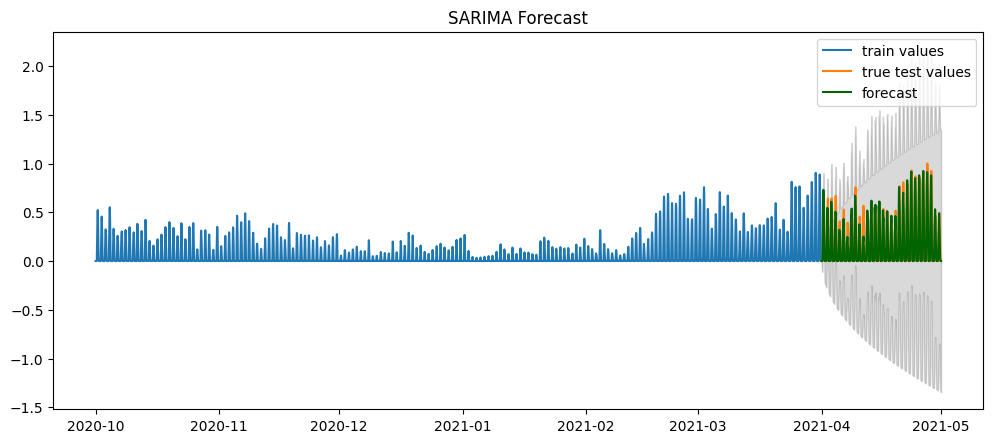

In [68]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

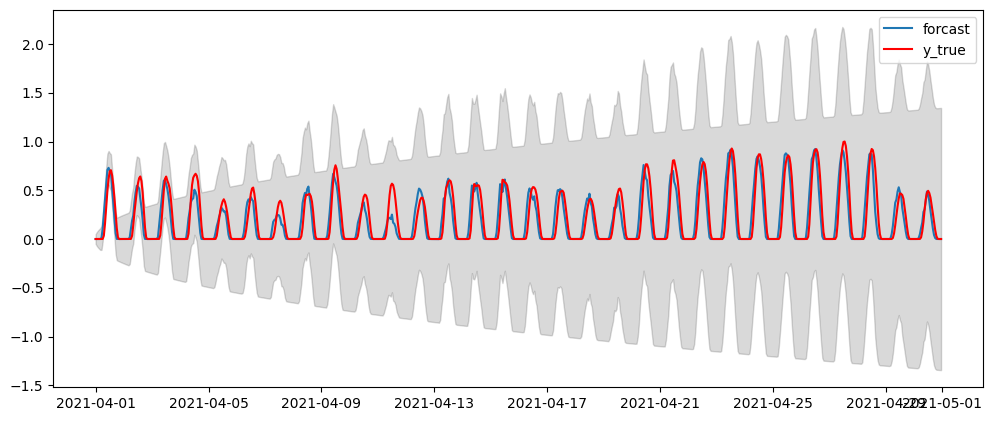

In [69]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

In [70]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(20,8), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

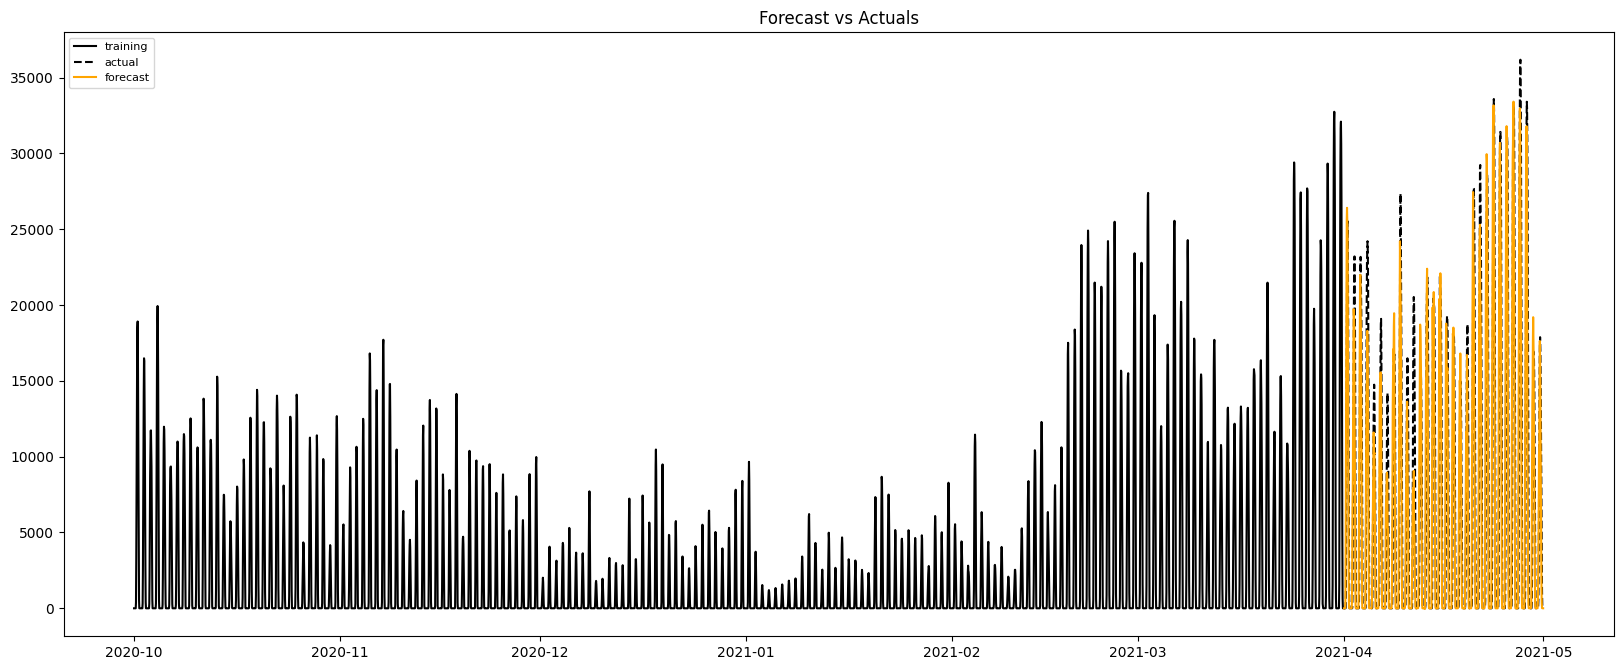

In [71]:
plot_forecast(unscaled_y_pred, unscaled_y_train, unscaled_y_test)

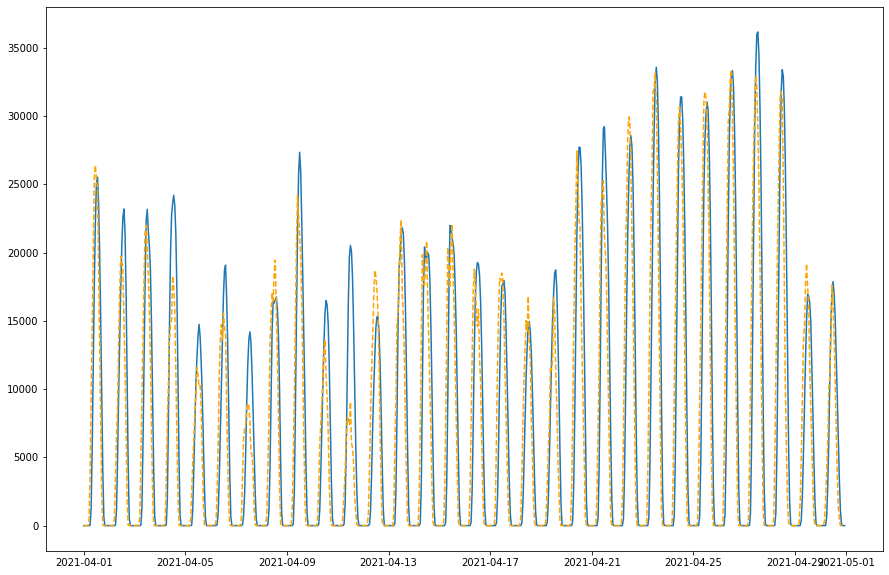

In [72]:
plt.figure(figsize=(15,10))
plt.plot(unscaled_y_test)
plt.plot(unscaled_y_pred, ls='--', c='orange');

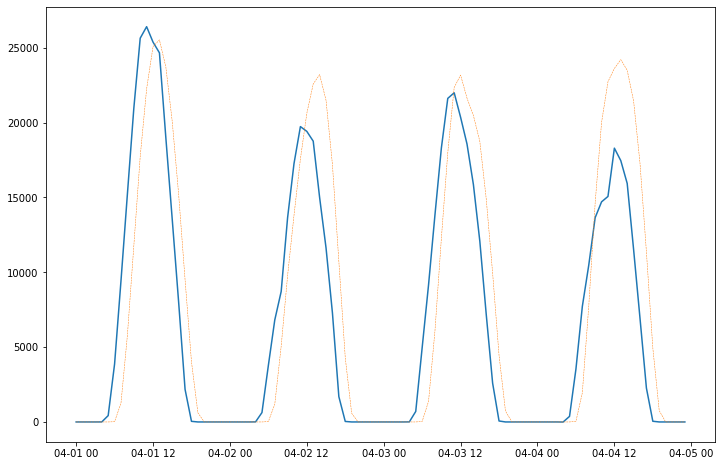

In [73]:
idx =24*4
plt.subplots(figsize=(12,8))
plt.plot(unscaled_y_pred.iloc[:idx])
plt.plot(unscaled_y_test.iloc[:idx], ls='--', lw=0.5);

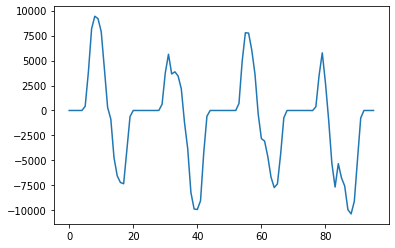

In [74]:
# plotting the residuals
plt.plot((unscaled_y_pred.iloc[:idx] - unscaled_y_test.iloc[:idx]).to_numpy().reshape(-1,1))

In [75]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    results = np.array([])
    for y_t, y_p in zip(y_true, y_pred):
        if y_t > 0:
            results = np.append(results, np.abs((y_t - y_p) / y_t))
    return results.mean()*100

In [102]:
# percentage of mean diferences
(unscaled_y_test-unscaled_y_pred).mean()/unscaled_y_test.mean()*100

6.660164543764105

In [77]:
# MSE
MSE = mse(unscaled_y_test, unscaled_y_pred)
MSE

23034282.017322663

In [78]:
# MAE
MAE = mae(y_test, central)
MAE

0.08826067819719706

In [79]:
# MAPE
MAPE = mean_absolute_percentage_error(y_test, central)
MAPE

3774.63183275577

# Save model (and scalers)

In [94]:
MODELS_DIR = '/Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data/models'

def save_model(path, scalers=False, model=False):
    if scalers:
        joblib.dump(feat_pipe, f'{path}/sun_feat_pipeline.pkl')
        joblib.dump(target_pipe, f'{path}/sun_target_pipeline.pkl')
    if model:
        sarimax.save(f'{path}/sun_model.pkl')

In [95]:
save_model(MODELS_DIR, scalers=True, model=False)

# Re-loading and testing model

In [96]:
pipo = joblib.load(f'{MODELS_DIR}/sun_feat_pipeline.pkl')

In [99]:
filtered_df

,13674,4177,3660,15000,4336,460,5100,5906,3098,2812,...,183,1605,1684,7351,5792,1757,1503,4104,5142,3946
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-30 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
from statsmodels.iolib.smpickle import load_pickle

sun_model = load_pickle('/Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data/models/sun_model.pkl')

In [106]:
scaler_y.inverse_transform(central.to_numpy().reshape(1,-1)).hape

(1, 720)